O objetivo do código aqui é determinar:

1. O nível de lag a ser utilizado nos modelos (usando RF de base)

2. Se o RF deve usar séries estacionárias ou não

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
import pandas as pd
import utils

In [9]:
# Importa dados estacionários com lags
df = pd.read_csv("dados/lags_transformados.csv", sep=";", decimal=",", thousands=".")
df = utils.index_to_period(df)
df

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,crb_metal_1,crb_metal_2,crb_metal_3,crb_metal_4,crb_metal_5,crb_metal_6,crb_metal_7,crb_metal_8,crb_metal_9,crb_metal_10
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59,-3.76
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,-11.13,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.23,0.51,0.000000,-23521679.0,37144204.0,-60304921.0,-53107060.0,3903.44,-0.0369,-0.740,...,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32,-28.60
2023-06,-0.08,0.04,0.000000,10468536.0,35565946.0,178689253.0,102168255.0,9751.93,-0.1312,-0.920,...,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32
2023-07,0.12,-0.07,0.000000,28855151.0,-22727138.0,-55577408.0,-34962544.0,3855.98,-0.0508,0.410,...,5.69,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46


In [10]:
y = df['ipca']
X = df.drop(columns=['ipca'])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=79)

In [11]:
# Limita seleção de parâmetros a sqrt(p), conforme ISL
regressor = RandomForestRegressor(max_features="sqrt")
fh = ForecastingHorizon(1, is_relative=True)
forecaster = make_reduction(regressor)
#forecaster.fit(y_train, X_train, fh=fh)

In [12]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
eval_df = evaluate(
    forecaster=forecaster,
    cv=cv,
    y=y,
    X=X,
    strategy="refit",
    return_data=True
)

In [13]:
# Transformações necessárias, pois 'evaluate' retorna 'y_pred' como série de séries
# numa coluna do DataFrame
y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])
y_pred.index = y_test.index
y_pred

C:\Users\asfra\AppData\Local\Temp\ipykernel_17032\537483885.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])


month
2017-03    0.4624
2017-04    0.4990
2017-05    0.3763
2017-06    0.2994
2017-07    0.3191
            ...  
2023-05    0.3375
2023-06    0.3678
2023-07    0.1763
2023-08    0.2747
2023-09    0.3844
Freq: M, Length: 79, dtype: float64

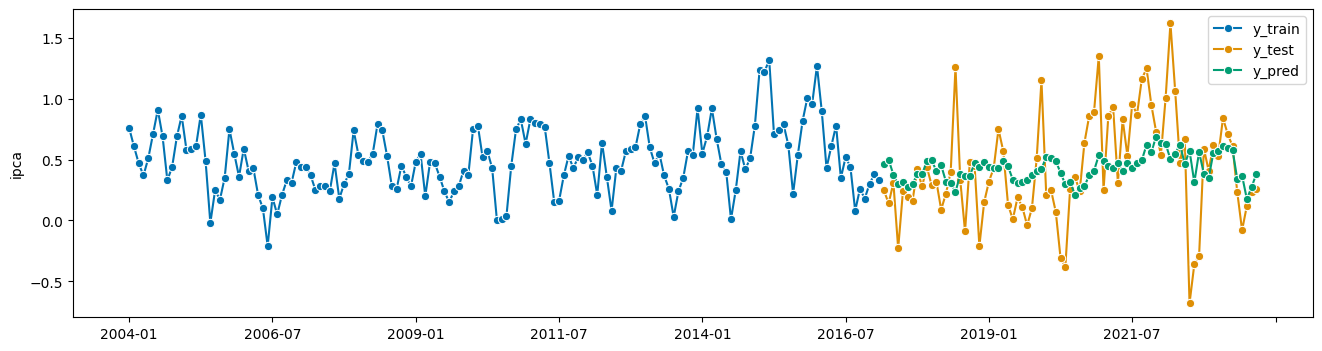

In [14]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(y_train, y_test, y_pred, labels=labels)

In [15]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_true=y_test, y_pred=y_pred)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.4607132835288985

In [13]:
fig.savefig("imagens/RF1.png")

Experimenta rodar sem lags

Replica os passos da tentativa anterior

In [17]:
no_lags = {}
no_lags['df'] = pd.read_csv("dados/dados_transformados.csv", sep=";", decimal=",", thousands=".")
no_lags['df'] = utils.index_to_period(no_lags['df'])
no_lags['df']

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,16.500000,101206857,408357097,850484302,968637026,21851.44,2.8518,88.177,...,58072.64,0.4,134.207300,88,124.2,14.696341,184357.2254,291.28,268.94,291.79
2004-02,0.61,0.90,16.500000,102857652,411584365,860505531,981337578,21755.02,2.9303,89.876,...,58101.64,0.3,255.601393,89,123.4,15.073171,184357.2254,301.39,283.68,316.06
2004-03,0.47,0.40,16.387097,101282219,413528931,870826987,989838137,22142.26,2.9055,87.099,...,60477.37,0.2,89.185225,84,113.3,16.078049,173974.6570,305.43,286.39,327.01
2004-04,0.37,0.21,16.116667,101821601,415095168,876412419,995559726,19607.23,2.9060,85.537,...,58565.69,0.2,110.461883,80,108.0,16.454878,173635.2378,304.98,292.74,315.88
2004-05,0.51,0.54,16.000000,103074482,429712981,908888294,1012425016,19544.67,3.1004,89.750,...,60054.59,0.2,125.354045,97,124.2,15.324390,173873.4968,299.67,277.72,323.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.23,0.51,13.750000,577826684,5322265166,10022339920,11110115291,108335.07,4.9828,53.920,...,39023.18,0.5,137.801645,205,122.2,8.300000,282700.0000,541.45,532.58,987.00
2023-06,-0.08,0.04,13.750000,588295220,5423979831,10218926744,11238752433,118087.00,4.8516,53.000,...,-24270.03,0.8,169.261123,179,125.3,8.000000,285243.0000,547.83,543.66,992.69
2023-07,0.12,-0.07,13.750000,617150371,5502967358,10359936160,11332427031,121942.98,4.8008,53.410,...,-80519.87,1.1,133.688711,133,124.5,7.900000,287672.0000,563.85,567.31,1021.05


In [21]:
no_lags['y'] = no_lags['df']['ipca']
no_lags['X'] = no_lags['df'].drop(columns=['ipca'])
no_lags['y_train'], no_lags['y_test'], no_lags['X_train'], no_lags['X_test'] = \
    temporal_train_test_split(y, X, test_size=79)

In [22]:
no_lags['X']

,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,ind_varejo,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.68,16.500000,101206857,408357097,850484302,968637026,21851.44,2.8518,88.177,18.15659,...,58072.64,0.4,134.207300,88,124.2,14.696341,184357.2254,291.28,268.94,291.79
2004-02,0.90,16.500000,102857652,411584365,860505531,981337578,21755.02,2.9303,89.876,17.36717,...,58101.64,0.3,255.601393,89,123.4,15.073171,184357.2254,301.39,283.68,316.06
2004-03,0.40,16.387097,101282219,413528931,870826987,989838137,22142.26,2.9055,87.099,18.90215,...,60477.37,0.2,89.185225,84,113.3,16.078049,173974.6570,305.43,286.39,327.01
2004-04,0.21,16.116667,101821601,415095168,876412419,995559726,19607.23,2.9060,85.537,19.03372,...,58565.69,0.2,110.461883,80,108.0,16.454878,173635.2378,304.98,292.74,315.88
2004-05,0.54,16.000000,103074482,429712981,908888294,1012425016,19544.67,3.1004,89.750,20.13013,...,60054.59,0.2,125.354045,97,124.2,15.324390,173873.4968,299.67,277.72,323.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.51,13.750000,577826684,5322265166,10022339920,11110115291,108335.07,4.9828,53.920,102.46743,...,39023.18,0.5,137.801645,205,122.2,8.300000,282700.0000,541.45,532.58,987.00
2023-06,0.04,13.750000,588295220,5423979831,10218926744,11238752433,118087.00,4.8516,53.000,100.18498,...,-24270.03,0.8,169.261123,179,125.3,8.000000,285243.0000,547.83,543.66,992.69
2023-07,-0.07,13.750000,617150371,5502967358,10359936160,11332427031,121942.98,4.8008,53.410,103.29504,...,-80519.87,1.1,133.688711,133,124.5,7.900000,287672.0000,563.85,567.31,1021.05


In [23]:
no_lags['regressor'] = RandomForestRegressor(max_features="sqrt")
fh = ForecastingHorizon(1, is_relative=True)
no_lags['forecaster'] = make_reduction(no_lags['regressor'])

In [24]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
no_lags['eval'] = evaluate(
    forecaster=no_lags['forecaster'],
    cv=cv,
    y=no_lags['y'],
    X=no_lags['X'],
    strategy="refit",
    return_data=True
)

In [25]:
no_lags['y_pred'] = pd.Series([value[0] for _, value in no_lags['eval']['y_pred'].items()])
no_lags['y_pred'].index = no_lags['y_test'].index
no_lags['y_pred']

C:\Users\asfra\AppData\Local\Temp\ipykernel_15760\1604661032.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_lags['y_pred'] = pd.Series([value[0] for _, value in no_lags['eval']['y_pred'].items()])


month
2017-03    0.4632
2017-04    0.3575
2017-05    0.3474
2017-06    0.2712
2017-07    0.1444
            ...  
2023-05    0.5102
2023-06    0.4439
2023-07    0.1484
2023-08    0.1587
2023-09    0.2707
Freq: M, Length: 79, dtype: float64

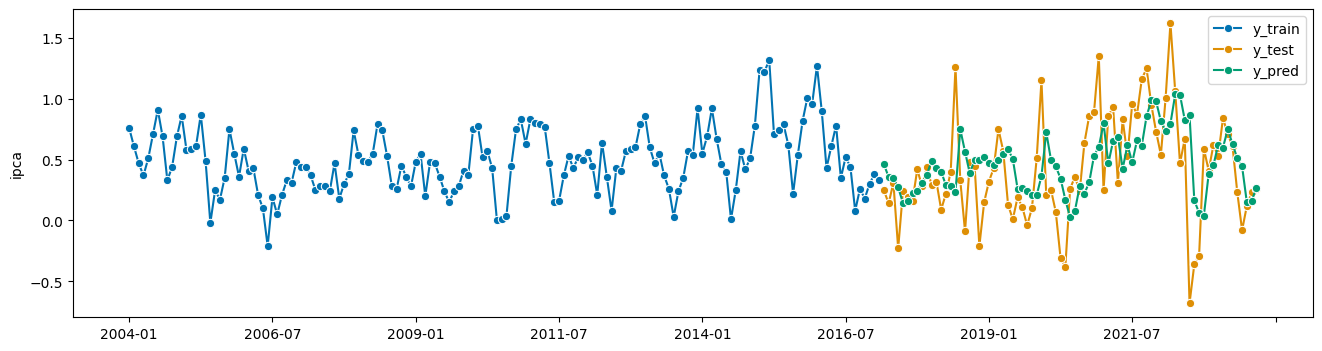

In [26]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(no_lags['y_train'], no_lags['y_test'], no_lags['y_pred'], labels=labels)

In [27]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_true=no_lags['y_test'], y_pred=no_lags['y_pred'])

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.683361688910373

In [29]:
no_lags['eval']

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.852800,0.596487,0.012561,158,2017-02,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-03 0.25 Freq: M, Name: ipca, dty...","2017-03 0.4632 Freq: M, Name: ipca, dtype: ..."
1,1.553571,0.574925,0.012486,159,2017-03,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-04 0.14 Freq: M, Name: ipca, dty...","2017-04 0.3575 Freq: M, Name: ipca, dtype: ..."
2,0.120645,0.609611,0.012569,160,2017-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-05 0.31 Freq: M, Name: ipca, dty...","2017-05 0.3474 Freq: M, Name: ipca, dtype: ..."
3,2.179130,0.586936,0.011164,161,2017-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-06 -0.23 Freq: M, Name: ipca, dty...","2017-06 0.2712 Freq: M, Name: ipca, dtype: ..."
4,0.398333,0.589004,0.011759,162,2017-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-07 0.24 Freq: M, Name: ipca, dty...","2017-07 0.1444 Freq: M, Name: ipca, dtype: ..."
...,...,...,...,...,...,...,...,...
74,1.218261,0.903180,0.013488,232,2023-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-05 0.23 Freq: M, Name: ipca, dty...","2023-05 0.5102 Freq: M, Name: ipca, dtype: ..."
75,6.548750,0.934673,0.014593,233,2023-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-06 -0.08 Freq: M, Name: ipca, dty...","2023-06 0.4439 Freq: M, Name: ipca, dtype: ..."
76,0.236667,0.894537,0.013285,234,2023-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-07 0.12 Freq: M, Name: ipca, dty...","2023-07 0.1484 Freq: M, Name: ipca, dtype: ..."
77,0.310000,0.899948,0.011344,235,2023-07,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-08 0.23 Freq: M, Name: ipca, dty...","2023-08 0.1587 Freq: M, Name: ipca, dtype: ..."


C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.1654927164556962